In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mmd import MMD_3_Sample_Test, grbf

seed=42
np.random.seed(seed)

# Data preparation

In [3]:
def generate_data_from_gaussians(mu_1, mu_2, sigma=1., gamma=0.5, n=250):
    """Generates data from three gaussians, one with interpolated mean from the other two."""
    y = np.random.multivariate_normal(mu_1, sigma*np.eye(2), n)
    z = np.random.multivariate_normal(mu_2, sigma*np.eye(2), n)
    x = np.random.multivariate_normal((1-gamma)*mu_1 + gamma*mu_2, sigma*np.eye(2), n)

    return x, y, z

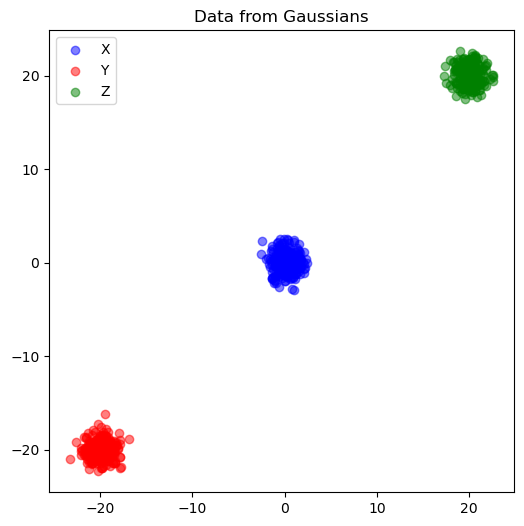

In [4]:
def plot_data(x, y, z, title):
    """Plots the data."""
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], color='blue', alpha=0.5, label='X')
    plt.scatter(y[:, 0], y[:, 1], color='red', alpha=0.5, label='Y')
    plt.scatter(z[:, 0], z[:, 1], color='green', alpha=0.5, label='Z')
    plt.legend()
    plt.title(title)
    plt.show()


X, Y, Z = generate_data_from_gaussians(np.array([-20, -20]), np.array([20, 20]))
plot_data(X, Y, Z, title='Data from Gaussians')

# Experiment with MMD test

Note on MMD-test:

MMD - Maximum Mean Disrepancy - distance between two means of distrubtions in some space $F$ (for which we can use kernel trick to compute inner-product <=> distances)

MMD-test: 
- $H_0$: $~~MMD(F, Px, Py) ≤ MMD(F, Px, Pz)$
- $H_1$: $~~MMD(F, Px, Py) > MMD(F, Px, Pz)$

In other words, $H_0$ is "$Y$ is closer to $X$ then $Z$"

## Plotting p-values for varying $\gamma$

In [4]:
mean1 = np.array([-5, -5])
mean2 = np.array([5, 5])
sigma=1.5

pvals = []
gamma_vals = []
num_iters=100
num_samples=50
for gamma in np.arange(0.1, 0.9, 2e-2):
    X, Y, Z = generate_data_from_gaussians(mean1, mean2, sigma, gamma=gamma)
    for _ in range(100):
        x_sample = X[np.random.choice(X.shape[0], size=num_samples, replace=False)]
        y_sample = Y[np.random.choice(Y.shape[0], size=num_samples, replace=False)]
        z_sample = Z[np.random.choice(Z.shape[0], size=num_samples, replace=False)]

        mmd = MMD_3_Sample_Test(x_sample, y_sample, z_sample, computeMMDs=False)
        pvalue, _, _, _, _ = mmd
        pvals.append(pvalue)
        
    gamma_vals += [gamma]*100

C:\Users\Natifick\Jupyter_Init\Skoltech\StatsProject\mmd.py:51: RuntimeWarning: invalid value encountered in sqrt
  pvalue = sp.stats.norm.cdf(-t/np.sqrt((Diff_Var)))
C:\Users\Natifick\Jupyter_Init\Skoltech\StatsProject\mmd.py:53: RuntimeWarning: invalid value encountered in sqrt
  tstat = t/sqrt(Diff_Var)


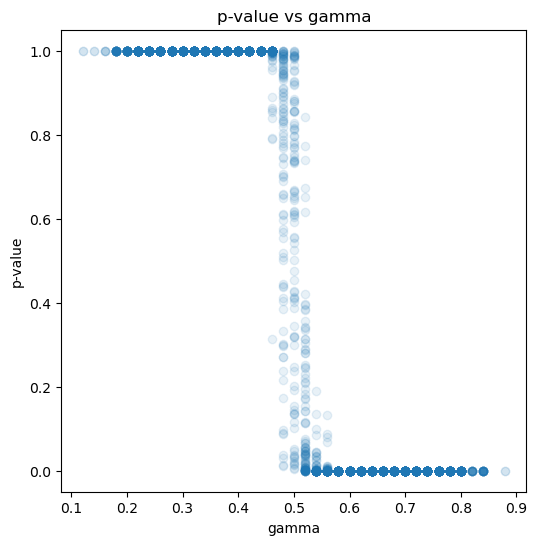

In [5]:
# plot p-values
plt.figure(figsize=(6, 6))
plt.scatter(gamma_vals, pvals, alpha=0.1)
plt.xlabel('gamma')
plt.ylabel('p-value')
plt.title('p-value vs gamma')
plt.show()

## Plotting scatter plot of joint statistics

In [6]:
X, Y, Z = generate_data_from_gaussians(
    mu_1=np.array([-5, -5]),
    mu_2=np.array([5, 5]),
    sigma=1.5,
    gamma=0.5
)

num_iters=1000
num_samples=50
statistics = []
for _ in range(num_iters):
    x_sample = X[np.random.choice(X.shape[0], size=num_samples, replace=False)]
    y_sample = Y[np.random.choice(Y.shape[0], size=num_samples, replace=False)]
    z_sample = Z[np.random.choice(Z.shape[0], size=num_samples, replace=False)]

    mmd = MMD_3_Sample_Test(x_sample, y_sample, z_sample, computeMMDs=True)
    statistics.append([mmd[-2], mmd[-1]])

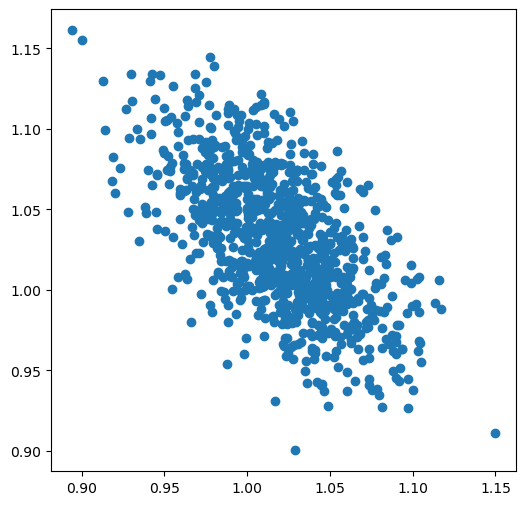

In [8]:
# plot scatter plot of joint statistics
plt.figure(figsize=(6, 6))

plt.scatter(statistics[:, 0], statistics[:, 1])
plt.show()

## Validation of Calibration

Appendix B: We show here that our derived test is well calibrated. A calibrated
test should output a uniform distribution of p-values when the two
MMD distances are equal.

### 1. - equivalently distant $\mu$'s

In [16]:
X, Y, Z = generate_data_from_gaussians(np.array([-20, -20]), np.array([20, 20]), gamma=0.5, sigma=10., n=1000)

pvalues = []
num_iters=1000
num_samples=100
for _ in range(num_iters):
    x_sample = X[np.random.choice(X.shape[0], size=num_samples, replace=False)]
    y_sample = Y[np.random.choice(Y.shape[0], size=num_samples, replace=False)]
    z_sample = Z[np.random.choice(Z.shape[0], size=num_samples, replace=False)]

    mmd = MMD_3_Sample_Test(x_sample, y_sample, z_sample, computeMMDs=False)
    pvalue, _, _, _, _ = mmd
    pvalues.append(pvalue)

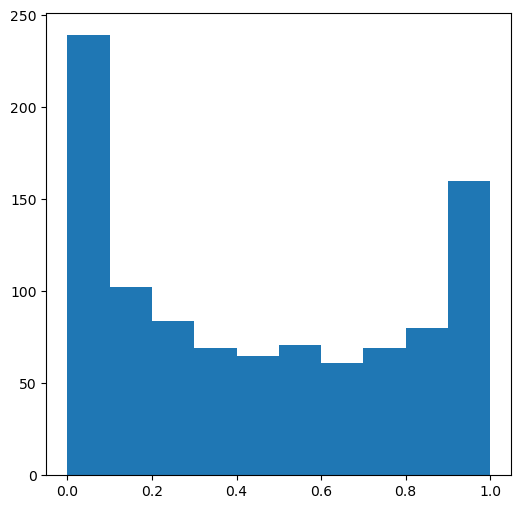

In [17]:
plt.figure(figsize=(6, 6))
plt.hist(pvalues)
plt.show()

### 2. - same $\mu$, rotated $X$

In [25]:
from math import pi

n=1000
Y = np.random.multivariate_normal([0, 0], np.diag([10, 1]), n)
Z = np.random.multivariate_normal([0, 0], np.diag([10, 1]), n)
X = np.random.multivariate_normal([0, 0], np.diag([10, 1]), n)

R = np.array([[np.cos(pi/2), -np.sin(pi/2)], [np.sin(pi/2), np.cos(pi/2)]])

X = X@R

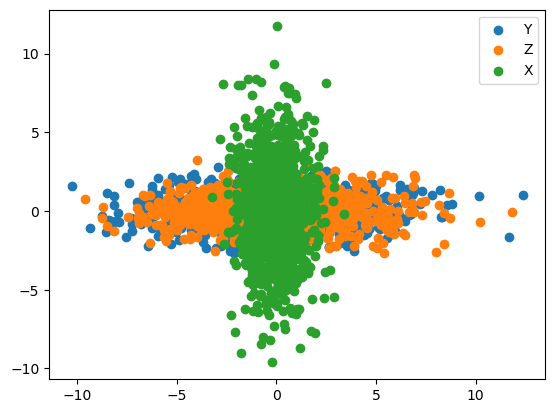

In [27]:
plt.scatter(Y[:, 0], Y[:, 1], label="Y")
plt.scatter(Z[:, 0],Z[:, 1], label="Z")
plt.scatter(X[:, 0], X[:, 1], label="X")
plt.legend()
plt.show()

In [34]:
pvalues = []
num_iters=1000
num_samples=60
for _ in range(num_iters):
    x_sample = X[np.random.choice(X.shape[0], size=num_samples, replace=False)]
    y_sample = Y[np.random.choice(Y.shape[0], size=num_samples, replace=False)]
    z_sample = Z[np.random.choice(Z.shape[0], size=num_samples, replace=False)]

    mmd = MMD_3_Sample_Test(x_sample, y_sample, z_sample, computeMMDs=False)
    pvalue, _, _, _, _ = mmd
    pvalues.append(pvalue)

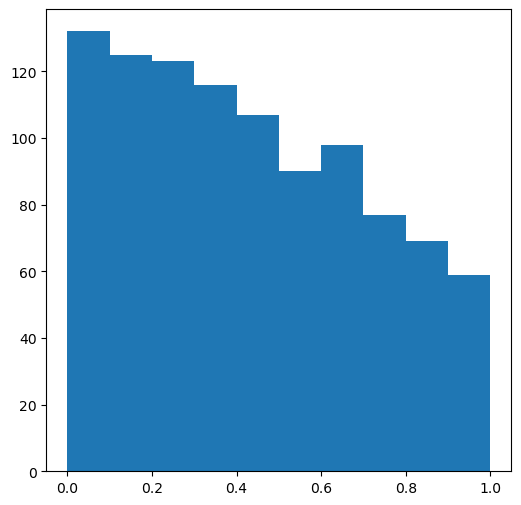

In [35]:
plt.figure(figsize=(6, 6))
plt.hist(pvalues)
plt.show()